In [1]:
import os
import numpy as np
import pandas as pd
import time
import glob
import pathlib
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from plotnine import *
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, mean_squared_error

import sys
sys.path.append("/tf/model/vggish")

import vggish_params 
import vggish_input
import mel_features

seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 200

BATCH_SIZE=32
DROPOUT=0.3
LEARNING_RATE=0.001
CLASSIFICATION_RATIO=0.99

In [4]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()
meta.Gender = meta.Gender.str.strip()

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
size_sec = 30
stride_sec = 1

In [8]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0]
    mmse = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    group = tf.gather(meta.Group.map({'cc': 0, 'cd': 1}), tf.where(tf.equal(names, name))[0][0])
    
    age = tf.gather(meta.Age, tf.where(tf.equal(names, name))[0][0])
    gender = tf.gather(meta.Gender.map({'male': 0, 'female': 1}), tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=int(_*size_sec), stride=int(_*stride_sec))
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, age, gender, mmse, group

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda spec, age, gender, mmse, group: tf.data.Dataset.zip((
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices(spec), 
                                        tf.data.Dataset.from_tensor_slices([age]),
                                        tf.data.Dataset.from_tensor_slices([gender]),
                                    )),
                                    tf.data.Dataset.zip((
                                        tf.data.Dataset.from_tensor_slices([mmse]), 
                                        tf.data.Dataset.from_tensor_slices([group]) 
                                    ))
                                )))\
                        .shuffle(100)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [11]:
for input, output in train_ds.take(1):
    input_shape = input[0].shape
    print(input_shape)
    print(input[1])
    print(input[2])
    print(output[0])
    print(output[1])


(30, 257, 1)
tf.Tensor(57, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(30, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [12]:
train_ds_b = train_ds.batch(BATCH_SIZE)
val_ds_b = val_ds.batch(BATCH_SIZE)

In [13]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x[0]))

In [14]:
specInput = layers.Input(shape=input_shape)
reshapeSpecInput = layers.Reshape((input_shape[0],input_shape[1]))(specInput)
normSpec = norm_layer(reshapeSpecInput)

ageInput = layers.Input(shape=(1,))
genderInput = layers.Input(shape=(1,))


dense1 = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(normSpec)
dropout1 = layers.Dropout(0.25)(dense1)
lstm1 = layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True)(dropout1)
dropout2 = layers.Dropout(0.25)(lstm1)
lstm2 = layers.LSTM(64, activation='relu', kernel_initializer='he_normal')(dropout2)
dropout3 = layers.Dropout(0.25)(lstm2)

concat = tf.keras.layers.Concatenate()([dropout3, ageInput, genderInput])

dense2 = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(concat)
dropout4 = layers.Dropout(0.25)(dense2)

mmse = layers.Dense(1, activation='relu', name='mmse')(dropout4)
classification = layers.Dense(1, activation='sigmoid', name='classification')(dropout4)

model = tf.keras.Model(
    inputs=[specInput, ageInput, genderInput],
    outputs=[mmse, classification],
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 257, 1)] 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 30, 257)      0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 30, 257)      3           reshape[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 30, 256)      66048       normalization[0][0]              
______________________________________________________________________________________________

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
    loss = ['mse','binary_crossentropy'],
    loss_weights=[1-CLASSIFICATION_RATIO, CLASSIFICATION_RATIO]
)

In [16]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=LEARNING_RATE))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=EARLY_STOPPING_PATIENCE, 
    restore_best_weights=True)

history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[lr_callback, es_callback]
)

Epoch 1/1000
3/3 [==============================] - 3s 831ms/step - loss: 18.3642 - mmse_loss: 723.9375 - classification_loss: 11.2372 - val_loss: 61.7711 - val_mmse_loss: 626.3125 - val_classification_loss: 56.0686
Epoch 2/1000
3/3 [==============================] - 0s 101ms/step - loss: 19.2810 - mmse_loss: 637.7394 - classification_loss: 13.0339 - val_loss: 11.6037 - val_mmse_loss: 599.6380 - val_classification_loss: 5.6640
Epoch 3/1000
3/3 [==============================] - 0s 100ms/step - loss: 13.8941 - mmse_loss: 573.8236 - classification_loss: 8.2382 - val_loss: 11.6819 - val_mmse_loss: 626.3125 - val_classification_loss: 5.4735
Epoch 4/1000
3/3 [==============================] - 0s 97ms/step - loss: 14.6824 - mmse_loss: 607.1120 - classification_loss: 8.6983 - val_loss: 9.4818 - val_mmse_loss: 626.3125 - val_classification_loss: 3.2511
Epoch 5/1000
3/3 [==============================] - 0s 102ms/step - loss: 16.3409 - mmse_loss: 617.2840 - classification_loss: 10.2708 - val_lo

3/3 [==============================] - 0s 105ms/step - loss: 10.7436 - mmse_loss: 610.9678 - classification_loss: 4.6807 - val_loss: 14.0270 - val_mmse_loss: 710.5621 - val_classification_loss: 6.9913
Epoch 40/1000
3/3 [==============================] - 0s 101ms/step - loss: 10.7978 - mmse_loss: 545.6436 - classification_loss: 5.3953 - val_loss: 7.1862 - val_mmse_loss: 643.9688 - val_classification_loss: 0.7540
Epoch 41/1000
3/3 [==============================] - 0s 100ms/step - loss: 13.3309 - mmse_loss: 628.3627 - classification_loss: 7.1185 - val_loss: 12.4938 - val_mmse_loss: 655.4723 - val_classification_loss: 5.9991
Epoch 42/1000
3/3 [==============================] - 0s 98ms/step - loss: 13.1947 - mmse_loss: 697.6554 - classification_loss: 6.2809 - val_loss: 15.2577 - val_mmse_loss: 632.6993 - val_classification_loss: 9.0209
Epoch 43/1000
3/3 [==============================] - 0s 101ms/step - loss: 11.9332 - mmse_loss: 597.7892 - classification_loss: 6.0154 - val_loss: 6.5967 - 

3/3 [==============================] - 0s 102ms/step - loss: 13.3031 - mmse_loss: 778.3527 - classification_loss: 5.5753 - val_loss: 14.1643 - val_mmse_loss: 595.6636 - val_classification_loss: 8.2906
Epoch 78/1000
3/3 [==============================] - 0s 106ms/step - loss: 7.5848 - mmse_loss: 490.5488 - classification_loss: 2.7064 - val_loss: 13.5971 - val_mmse_loss: 577.4688 - val_classification_loss: 7.9014
Epoch 79/1000
3/3 [==============================] - 0s 106ms/step - loss: 9.0133 - mmse_loss: 523.2871 - classification_loss: 3.8186 - val_loss: 14.1162 - val_mmse_loss: 600.9474 - val_classification_loss: 8.1886
Epoch 80/1000
3/3 [==============================] - 0s 109ms/step - loss: 8.6950 - mmse_loss: 557.7235 - classification_loss: 3.1493 - val_loss: 6.5423 - val_mmse_loss: 584.0051 - val_classification_loss: 0.7093
Epoch 81/1000
3/3 [==============================] - 0s 102ms/step - loss: 8.9578 - mmse_loss: 502.8129 - classification_loss: 3.9694 - val_loss: 8.1521 - val

3/3 [==============================] - 0s 97ms/step - loss: 6.1187 - mmse_loss: 214.5946 - classification_loss: 4.0129 - val_loss: 2.3831 - val_mmse_loss: 94.7763 - val_classification_loss: 1.4498
Epoch 116/1000
3/3 [==============================] - 0s 101ms/step - loss: 7.9460 - mmse_loss: 355.6802 - classification_loss: 4.4335 - val_loss: 3.4776 - val_mmse_loss: 215.4803 - val_classification_loss: 1.3362
Epoch 117/1000
3/3 [==============================] - 0s 100ms/step - loss: 5.5090 - mmse_loss: 227.5118 - classification_loss: 3.2666 - val_loss: 4.2127 - val_mmse_loss: 290.7879 - val_classification_loss: 1.3180
Epoch 118/1000
3/3 [==============================] - 0s 102ms/step - loss: 7.6157 - mmse_loss: 188.5849 - classification_loss: 5.7878 - val_loss: 4.8162 - val_mmse_loss: 347.3251 - val_classification_loss: 1.3565
Epoch 119/1000
3/3 [==============================] - 0s 105ms/step - loss: 6.0460 - mmse_loss: 231.1154 - classification_loss: 3.7725 - val_loss: 5.5523 - val_m

3/3 [==============================] - 0s 102ms/step - loss: 5.6809 - mmse_loss: 220.4173 - classification_loss: 3.5118 - val_loss: 1.6229 - val_mmse_loss: 90.8496 - val_classification_loss: 0.7216
Epoch 154/1000
3/3 [==============================] - 0s 102ms/step - loss: 4.5959 - mmse_loss: 207.0022 - classification_loss: 2.5514 - val_loss: 1.8875 - val_mmse_loss: 100.5641 - val_classification_loss: 0.8907
Epoch 155/1000
3/3 [==============================] - 0s 99ms/step - loss: 6.3163 - mmse_loss: 292.7639 - classification_loss: 3.4229 - val_loss: 1.9335 - val_mmse_loss: 98.9948 - val_classification_loss: 0.9531
Epoch 156/1000
3/3 [==============================] - 0s 99ms/step - loss: 5.0665 - mmse_loss: 223.6584 - classification_loss: 2.8585 - val_loss: 1.9718 - val_mmse_loss: 101.0267 - val_classification_loss: 0.9712
Epoch 157/1000
3/3 [==============================] - 0s 102ms/step - loss: 6.1367 - mmse_loss: 260.8205 - classification_loss: 3.5641 - val_loss: 1.9247 - val_mms

3/3 [==============================] - 0s 102ms/step - loss: 4.2896 - mmse_loss: 168.9716 - classification_loss: 2.6261 - val_loss: 1.6594 - val_mmse_loss: 66.7447 - val_classification_loss: 1.0019
Epoch 192/1000
3/3 [==============================] - 0s 95ms/step - loss: 4.7350 - mmse_loss: 159.2025 - classification_loss: 3.1747 - val_loss: 1.6689 - val_mmse_loss: 66.6502 - val_classification_loss: 1.0126
Epoch 193/1000
3/3 [==============================] - 0s 106ms/step - loss: 3.5851 - mmse_loss: 121.8147 - classification_loss: 2.3908 - val_loss: 1.6874 - val_mmse_loss: 68.6409 - val_classification_loss: 1.0111
Epoch 194/1000
3/3 [==============================] - 0s 102ms/step - loss: 3.6006 - mmse_loss: 176.4204 - classification_loss: 1.8549 - val_loss: 1.5914 - val_mmse_loss: 67.0927 - val_classification_loss: 0.9298
Epoch 195/1000
3/3 [==============================] - 0s 99ms/step - loss: 4.2730 - mmse_loss: 171.0105 - classification_loss: 2.5888 - val_loss: 1.4237 - val_mmse_

3/3 [==============================] - 0s 105ms/step - loss: 3.7423 - mmse_loss: 139.1317 - classification_loss: 2.3747 - val_loss: 1.2718 - val_mmse_loss: 48.4434 - val_classification_loss: 0.7953
Epoch 230/1000
3/3 [==============================] - 0s 98ms/step - loss: 3.4622 - mmse_loss: 179.7482 - classification_loss: 1.6815 - val_loss: 1.5158 - val_mmse_loss: 50.2239 - val_classification_loss: 1.0238
Epoch 231/1000
3/3 [==============================] - 0s 101ms/step - loss: 3.9365 - mmse_loss: 135.2267 - classification_loss: 2.6103 - val_loss: 1.6089 - val_mmse_loss: 49.8099 - val_classification_loss: 1.1220
Epoch 232/1000
3/3 [==============================] - 0s 103ms/step - loss: 3.2118 - mmse_loss: 160.0189 - classification_loss: 1.6279 - val_loss: 1.5112 - val_mmse_loss: 49.8433 - val_classification_loss: 1.0230
Epoch 233/1000
3/3 [==============================] - 0s 101ms/step - loss: 3.5937 - mmse_loss: 121.7122 - classification_loss: 2.4005 - val_loss: 1.3891 - val_mmse

3/3 [==============================] - 0s 98ms/step - loss: 3.1796 - mmse_loss: 150.9402 - classification_loss: 1.6870 - val_loss: 1.3977 - val_mmse_loss: 68.2411 - val_classification_loss: 0.7225
Epoch 268/1000
3/3 [==============================] - 0s 105ms/step - loss: 2.7183 - mmse_loss: 113.4315 - classification_loss: 1.5999 - val_loss: 1.3406 - val_mmse_loss: 67.7361 - val_classification_loss: 0.6699
Epoch 269/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.3864 - mmse_loss: 101.6679 - classification_loss: 1.3835 - val_loss: 1.3000 - val_mmse_loss: 65.6880 - val_classification_loss: 0.6496
Epoch 270/1000
3/3 [==============================] - 0s 142ms/step - loss: 2.5698 - mmse_loss: 110.2685 - classification_loss: 1.4819 - val_loss: 1.2899 - val_mmse_loss: 64.0770 - val_classification_loss: 0.6557
Epoch 271/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.1943 - mmse_loss: 111.9676 - classification_loss: 1.0855 - val_loss: 1.2580 - val_mmse_

3/3 [==============================] - 0s 101ms/step - loss: 2.4725 - mmse_loss: 142.7505 - classification_loss: 1.0556 - val_loss: 1.2510 - val_mmse_loss: 60.4587 - val_classification_loss: 0.6530
Epoch 306/1000
3/3 [==============================] - 0s 93ms/step - loss: 2.9337 - mmse_loss: 115.4164 - classification_loss: 1.7975 - val_loss: 1.2371 - val_mmse_loss: 64.0762 - val_classification_loss: 0.6024
Epoch 307/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.4816 - mmse_loss: 122.8714 - classification_loss: 1.2655 - val_loss: 1.2840 - val_mmse_loss: 66.3180 - val_classification_loss: 0.6271
Epoch 308/1000
3/3 [==============================] - 0s 100ms/step - loss: 2.3160 - mmse_loss: 133.8291 - classification_loss: 0.9876 - val_loss: 1.3048 - val_mmse_loss: 65.8944 - val_classification_loss: 0.6524
Epoch 309/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.2755 - mmse_loss: 111.0700 - classification_loss: 1.1766 - val_loss: 1.3236 - val_mmse

3/3 [==============================] - 0s 105ms/step - loss: 2.3582 - mmse_loss: 98.5841 - classification_loss: 1.3862 - val_loss: 1.2286 - val_mmse_loss: 66.1268 - val_classification_loss: 0.5730
Epoch 344/1000
3/3 [==============================] - 0s 111ms/step - loss: 2.1652 - mmse_loss: 90.9324 - classification_loss: 1.2686 - val_loss: 1.1967 - val_mmse_loss: 62.4402 - val_classification_loss: 0.5781
Epoch 345/1000
3/3 [==============================] - 0s 104ms/step - loss: 2.8098 - mmse_loss: 118.9405 - classification_loss: 1.6368 - val_loss: 1.2077 - val_mmse_loss: 58.7474 - val_classification_loss: 0.6265
Epoch 346/1000
3/3 [==============================] - 0s 106ms/step - loss: 2.5663 - mmse_loss: 94.1082 - classification_loss: 1.6416 - val_loss: 1.1870 - val_mmse_loss: 56.9893 - val_classification_loss: 0.6233
Epoch 347/1000
3/3 [==============================] - 0s 100ms/step - loss: 2.1065 - mmse_loss: 102.7906 - classification_loss: 1.0895 - val_loss: 1.1585 - val_mmse_l

Epoch 382/1000
3/3 [==============================] - 0s 104ms/step - loss: 1.8586 - mmse_loss: 99.1873 - classification_loss: 0.8755 - val_loss: 1.1118 - val_mmse_loss: 69.1618 - val_classification_loss: 0.4244
Epoch 383/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.7671 - mmse_loss: 133.4957 - classification_loss: 1.4466 - val_loss: 1.0912 - val_mmse_loss: 67.4497 - val_classification_loss: 0.4209
Epoch 384/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.0029 - mmse_loss: 99.9083 - classification_loss: 1.0139 - val_loss: 1.0622 - val_mmse_loss: 64.2886 - val_classification_loss: 0.4236
Epoch 385/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.9610 - mmse_loss: 88.4481 - classification_loss: 1.0874 - val_loss: 1.0646 - val_mmse_loss: 64.2423 - val_classification_loss: 0.4264
Epoch 386/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.3437 - mmse_loss: 128.0601 - classification_loss: 1.0738 - val_loss: 1.0638

3/3 [==============================] - 0s 102ms/step - loss: 2.2364 - mmse_loss: 111.8162 - classification_loss: 1.1295 - val_loss: 1.0398 - val_mmse_loss: 59.7873 - val_classification_loss: 0.4464
Epoch 421/1000
3/3 [==============================] - 0s 107ms/step - loss: 1.5333 - mmse_loss: 81.7825 - classification_loss: 0.7227 - val_loss: 1.0274 - val_mmse_loss: 58.3022 - val_classification_loss: 0.4489
Epoch 422/1000
3/3 [==============================] - 0s 103ms/step - loss: 2.0066 - mmse_loss: 85.0741 - classification_loss: 1.1676 - val_loss: 1.0204 - val_mmse_loss: 56.0356 - val_classification_loss: 0.4647
Epoch 423/1000
3/3 [==============================] - 0s 104ms/step - loss: 2.0556 - mmse_loss: 104.5851 - classification_loss: 1.0200 - val_loss: 1.0198 - val_mmse_loss: 53.5217 - val_classification_loss: 0.4895
Epoch 424/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.8125 - mmse_loss: 78.9305 - classification_loss: 1.0335 - val_loss: 1.0511 - val_mmse_l

Epoch 459/1000
3/3 [==============================] - 0s 104ms/step - loss: 2.5331 - mmse_loss: 108.5289 - classification_loss: 1.4624 - val_loss: 1.1842 - val_mmse_loss: 57.7180 - val_classification_loss: 0.6132
Epoch 460/1000
3/3 [==============================] - 0s 99ms/step - loss: 1.7241 - mmse_loss: 67.5318 - classification_loss: 1.0593 - val_loss: 1.1711 - val_mmse_loss: 57.9259 - val_classification_loss: 0.5978
Epoch 461/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.8256 - mmse_loss: 102.9204 - classification_loss: 0.8045 - val_loss: 1.1839 - val_mmse_loss: 61.9624 - val_classification_loss: 0.5700
Epoch 462/1000
3/3 [==============================] - 0s 107ms/step - loss: 1.5035 - mmse_loss: 67.4002 - classification_loss: 0.8378 - val_loss: 1.0886 - val_mmse_loss: 60.6474 - val_classification_loss: 0.4870
Epoch 463/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.3523 - mmse_loss: 86.2598 - classification_loss: 0.4947 - val_loss: 1.050

Epoch 498/1000
3/3 [==============================] - 0s 105ms/step - loss: 2.1337 - mmse_loss: 80.6382 - classification_loss: 1.3407 - val_loss: 1.1021 - val_mmse_loss: 62.4931 - val_classification_loss: 0.4820
Epoch 499/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.6660 - mmse_loss: 72.5109 - classification_loss: 0.9504 - val_loss: 1.1030 - val_mmse_loss: 62.1502 - val_classification_loss: 0.4863
Epoch 500/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.8871 - mmse_loss: 110.9898 - classification_loss: 0.7851 - val_loss: 1.1056 - val_mmse_loss: 61.5008 - val_classification_loss: 0.4955
Epoch 501/1000
3/3 [==============================] - 0s 105ms/step - loss: 1.7015 - mmse_loss: 87.5853 - classification_loss: 0.8340 - val_loss: 1.0983 - val_mmse_loss: 60.8656 - val_classification_loss: 0.4946
Epoch 502/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.8343 - mmse_loss: 93.3925 - classification_loss: 0.9095 - val_loss: 1.074

Epoch 537/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.9984 - mmse_loss: 99.5216 - classification_loss: 1.0133 - val_loss: 1.0824 - val_mmse_loss: 51.2666 - val_classification_loss: 0.5755
Epoch 538/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.9659 - mmse_loss: 91.2847 - classification_loss: 1.0637 - val_loss: 1.0764 - val_mmse_loss: 52.3237 - val_classification_loss: 0.5588
Epoch 539/1000
3/3 [==============================] - 0s 108ms/step - loss: 1.4377 - mmse_loss: 80.3448 - classification_loss: 0.6406 - val_loss: 1.0568 - val_mmse_loss: 53.0171 - val_classification_loss: 0.5320
Epoch 540/1000
3/3 [==============================] - 0s 99ms/step - loss: 1.5355 - mmse_loss: 74.0132 - classification_loss: 0.8034 - val_loss: 1.0321 - val_mmse_loss: 53.3193 - val_classification_loss: 0.5039
Epoch 541/1000
3/3 [==============================] - 0s 104ms/step - loss: 1.7318 - mmse_loss: 94.2032 - classification_loss: 0.7977 - val_loss: 1.0119 -

Epoch 576/1000
3/3 [==============================] - 0s 99ms/step - loss: 2.1585 - mmse_loss: 95.4914 - classification_loss: 1.2157 - val_loss: 1.0199 - val_mmse_loss: 59.5185 - val_classification_loss: 0.4290
Epoch 577/1000
3/3 [==============================] - 0s 106ms/step - loss: 1.6361 - mmse_loss: 82.9587 - classification_loss: 0.8146 - val_loss: 1.0210 - val_mmse_loss: 59.5705 - val_classification_loss: 0.4296
Epoch 578/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.9088 - mmse_loss: 87.0999 - classification_loss: 1.0483 - val_loss: 1.0361 - val_mmse_loss: 60.5650 - val_classification_loss: 0.4348
Epoch 579/1000
3/3 [==============================] - 0s 96ms/step - loss: 1.5189 - mmse_loss: 89.1972 - classification_loss: 0.6332 - val_loss: 1.0011 - val_mmse_loss: 57.4337 - val_classification_loss: 0.4311
Epoch 580/1000
3/3 [==============================] - 0s 105ms/step - loss: 1.6270 - mmse_loss: 85.3163 - classification_loss: 0.7816 - val_loss: 0.9596 -

Epoch 615/1000
3/3 [==============================] - 0s 99ms/step - loss: 1.2201 - mmse_loss: 69.5059 - classification_loss: 0.5303 - val_loss: 0.9632 - val_mmse_loss: 51.0544 - val_classification_loss: 0.4573
Epoch 616/1000
3/3 [==============================] - 0s 109ms/step - loss: 1.6942 - mmse_loss: 103.2171 - classification_loss: 0.6687 - val_loss: 0.9546 - val_mmse_loss: 49.7420 - val_classification_loss: 0.4618
Epoch 617/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.7727 - mmse_loss: 92.0654 - classification_loss: 0.8607 - val_loss: 0.9497 - val_mmse_loss: 49.1846 - val_classification_loss: 0.4625
Epoch 618/1000
3/3 [==============================] - 0s 99ms/step - loss: 1.2428 - mmse_loss: 74.9918 - classification_loss: 0.4979 - val_loss: 0.9481 - val_mmse_loss: 48.1423 - val_classification_loss: 0.4714
Epoch 619/1000
3/3 [==============================] - 0s 147ms/step - loss: 1.4242 - mmse_loss: 88.2768 - classification_loss: 0.5469 - val_loss: 0.9431 

Epoch 654/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.4071 - mmse_loss: 59.9412 - classification_loss: 0.8159 - val_loss: 1.2037 - val_mmse_loss: 56.1645 - val_classification_loss: 0.6485
Epoch 655/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.2345 - mmse_loss: 73.0873 - classification_loss: 0.5087 - val_loss: 1.1733 - val_mmse_loss: 55.5413 - val_classification_loss: 0.6241
Epoch 656/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.4316 - mmse_loss: 81.0904 - classification_loss: 0.6269 - val_loss: 1.0941 - val_mmse_loss: 51.9607 - val_classification_loss: 0.5803
Epoch 657/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.3801 - mmse_loss: 67.7870 - classification_loss: 0.7093 - val_loss: 1.0250 - val_mmse_loss: 45.0251 - val_classification_loss: 0.5806
Epoch 658/1000
3/3 [==============================] - 0s 110ms/step - loss: 1.6501 - mmse_loss: 99.4473 - classification_loss: 0.6623 - val_loss: 1.0238 -

Epoch 693/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.5879 - mmse_loss: 66.9880 - classification_loss: 0.9272 - val_loss: 1.0811 - val_mmse_loss: 49.6400 - val_classification_loss: 0.5906
Epoch 694/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.2234 - mmse_loss: 73.8648 - classification_loss: 0.4897 - val_loss: 1.1000 - val_mmse_loss: 48.5909 - val_classification_loss: 0.6203
Epoch 695/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.3624 - mmse_loss: 70.5589 - classification_loss: 0.6634 - val_loss: 1.1091 - val_mmse_loss: 49.5248 - val_classification_loss: 0.6201
Epoch 696/1000
3/3 [==============================] - 0s 103ms/step - loss: 1.1835 - mmse_loss: 59.2911 - classification_loss: 0.5965 - val_loss: 1.1317 - val_mmse_loss: 51.4193 - val_classification_loss: 0.6237
Epoch 697/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.1290 - mmse_loss: 74.5542 - classification_loss: 0.3874 - val_loss: 1.1398

Epoch 732/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.0771 - mmse_loss: 62.6916 - classification_loss: 0.4547 - val_loss: 1.1758 - val_mmse_loss: 53.1094 - val_classification_loss: 0.6512
Epoch 733/1000
3/3 [==============================] - 0s 101ms/step - loss: 2.1018 - mmse_loss: 80.2369 - classification_loss: 1.3125 - val_loss: 1.2240 - val_mmse_loss: 58.3312 - val_classification_loss: 0.6472
Epoch 734/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.2376 - mmse_loss: 71.1554 - classification_loss: 0.5314 - val_loss: 1.2460 - val_mmse_loss: 61.0478 - val_classification_loss: 0.6419
Epoch 735/1000
3/3 [==============================] - 0s 107ms/step - loss: 1.8296 - mmse_loss: 100.3248 - classification_loss: 0.8347 - val_loss: 1.1912 - val_mmse_loss: 59.7297 - val_classification_loss: 0.5999
Epoch 736/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.3295 - mmse_loss: 80.1754 - classification_loss: 0.5331 - val_loss: 1.1083

Epoch 771/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.1369 - mmse_loss: 67.8620 - classification_loss: 0.4629 - val_loss: 1.5331 - val_mmse_loss: 45.5042 - val_classification_loss: 1.0889
Epoch 772/1000
3/3 [==============================] - 0s 101ms/step - loss: 1.0475 - mmse_loss: 69.2968 - classification_loss: 0.3581 - val_loss: 1.3489 - val_mmse_loss: 42.9318 - val_classification_loss: 0.9289
Epoch 773/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.3887 - mmse_loss: 74.6288 - classification_loss: 0.6489 - val_loss: 1.1442 - val_mmse_loss: 42.7176 - val_classification_loss: 0.7242
Epoch 774/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.9440 - mmse_loss: 45.5263 - classification_loss: 0.4937 - val_loss: 1.0658 - val_mmse_loss: 45.4628 - val_classification_loss: 0.6173
Epoch 775/1000
3/3 [==============================] - 0s 102ms/step - loss: 1.1741 - mmse_loss: 61.6684 - classification_loss: 0.5631 - val_loss: 1.0683 

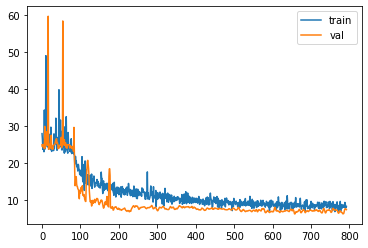

In [17]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mmse_loss']), np.sqrt(metrics['val_mmse_loss']))
plt.legend(['train', 'val'])
plt.show()

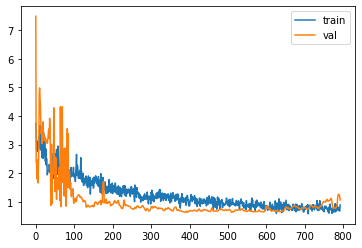

In [18]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['classification_loss']), np.sqrt(metrics['val_classification_loss']))
plt.legend(['train', 'val'])
plt.show()

In [19]:
model.predict(preprocess_dataset([train_files[2]]).batch(1))[0].flatten()[0]

20.142738

In [20]:
meta = meta.assign(split = '', predict_mmse = -99.99, predict_group_prob = 0)

def applyModelStats(file, split_type):
    
    id = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    
    meta.loc[meta["ID"]==id,'split'] = split_type
    predict = model.predict(preprocess_dataset([file]).batch(1))
    
    mmse = predict[0].flatten()[0]
    group_prob = predict[1].flatten()[0]
    
    median_predict = np.percentile(predict[0].flatten()[0], 50)   
    predict25 = np.percentile(predict[0].flatten()[0], 25)   
    predict75 = np.percentile(predict[0].flatten()[0], 75)   
    
    avg_predict_group_prob = np.median(predict[1][:,0])
    std_predict_group_prob = np.std(predict[1][:,0])
    
    meta.loc[meta["ID"]==id,'predict_mmse'] = mmse    
    meta.loc[meta["ID"]==id,'predict_group_prob'] = group_prob


for file in train_files:
    applyModelStats(file, "train")
    
for file in val_files:
    applyModelStats(file, "val")
    
for file in test_files:
    applyModelStats(file, "test")

In [21]:
meta

,index,ID,Age,Gender,MMSE,Group,split,predict_mmse,predict_group_prob
0,0,S001,74,male,30,cc,train,26.587410,0.028236
1,1,S002,62,female,30,cc,train,21.104120,0.288861
2,2,S003,69,female,29,cc,train,29.012899,0.004736
3,3,S004,71,female,30,cc,test,24.505810,0.021365
4,4,S005,74,female,30,cc,val,22.563841,0.318241
...,...,...,...,...,...,...,...,...,...
103,49,S150,58,male,20,cd,train,17.489710,0.999995
104,50,S151,72,male,24,cd,train,18.831264,0.999986
105,51,S153,68,female,12,cd,val,11.422080,0.999996
106,52,S154,65,female,20,cd,train,21.909721,0.671515


In [22]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict_mmse'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,9.204291
1,train,4.595604
2,val,6.718170


In [23]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,5.790037
1,male,6.011897


In [24]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict_mmse'] ))

5.889673334754675

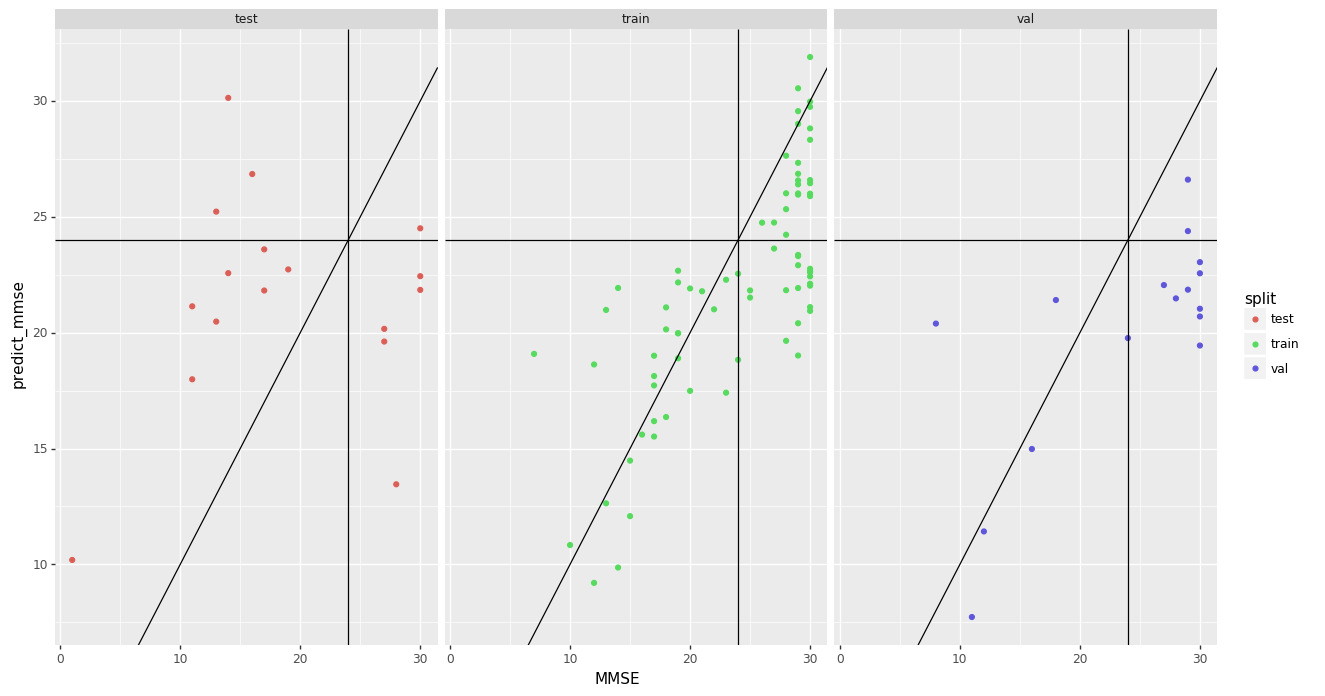

<ggplot: (-9223363264933201646)>

In [25]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict_mmse', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

Logistic: ROC AUC = 0.890


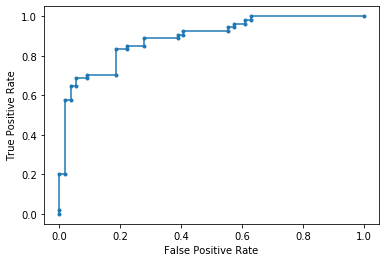

In [26]:
y = meta.Group.apply(lambda x: 1 if x=="cd" else 0)
probs = meta.predict_group_prob

lr_auc = roc_auc_score(y, probs)

# summarize scores
print('Logistic: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the plot
plt.show()

In [27]:
# model.save('saved_model/base_line/20210222')

In [28]:
ls saved_model/base_line

20210210/  20210217/  20210222/  20210225/
